In [120]:
import graphviz
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
from io import StringIO
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score


np.random.seed(100)

# Only for the sake of cleaner output in this example
logging.getLogger("pgmpy").setLevel(logging.ERROR)  

# Functions

In [121]:
def get_OR_for_treatment(df_a, df_b, outcome_col='lung_cancer_death'):
    a = df_a[outcome_col].sum()
    b = len(df_a) - a

    c = df_b[outcome_col].sum()
    d = len(df_b) - c

    OR = (a / b) / (c / d)

    return OR

# Define the Conditional Probability Distributions (CPDs)

In [122]:
cpd_residential_location = TabularCPD(
    variable='residential_location',
    variable_card=2,
    values=[[0.8], [0.2]],
    state_names={'residential_location': ['Urban', 'Rural']}
).normalize(inplace=False)

cpd_smoking = TabularCPD(
    variable='smoking',
    variable_card=2,
    values=[
        [0.1, 0.9],  # smoking = 'No'
        [0.9, 0.1]   # smoking = 'Yes'
    ],
    evidence=['residential_location'],
    evidence_card=[2],
    state_names={
        'smoking': ['No', 'Yes'],
        'residential_location': ['Urban', 'Rural']
    }
).normalize(inplace=False)

cpd_lung_function = TabularCPD(
    variable='lung_function',
    variable_card=3,
    values=[
        # +-------+-------+-------+-------+
        # |  no   |  no   |  yes  |  yes  |
        # +-------+-------+-------+-------+
        # | urban | rural | urban | rural |
        # +-------+-------+-------+-------+
        [0.3, 0.3, 0.5, 0.4],  # lung_function = 'impaired'
        [0.5, 0.6, 0.1, 0.1],  # lung_function = 'normal'
        [0.2, 0.2, 0.6, 0.4]   # lung_function = 'severely impaired'
        # [0.35, 0.2, 0.55, 0.4],  # lung_function = 'impaired'
        # [0.25, 0.4, 0.45, 0.3],  # lung_function = 'normal'
        # [0.35, 0.2, 0.65, 0.5]   # lung_function = 'severely impaired'
    ],
    evidence=['smoking', 'residential_location'],
    evidence_card=[2, 2],
    state_names={
        'lung_function': ['impaired', 'normal', 'severely_impaired'],
        'smoking': ['No', 'Yes'],
        'residential_location': ['Urban', 'Rural']
    }
).normalize(inplace=False)

cpd_lung_cancer_death = TabularCPD(
    variable='lung_cancer_death',
    variable_card=2,
    values=[
        # +----------+--------+-------------------+----------+--------+-------------------+
        # |    no    |   no   |        no         |   yes    |  yes   |        yes        |
        # +----------+--------+-------------------+----------+--------+-------------------+
        # | impaired | normal | severely_impaired | impaired | normal | severely_impaired |
        # +----------+--------+-------------------+----------+--------+-------------------+
        [0.5, 0.5, 0.5, 0.2, 0.2, 0.2],  # lung_cancer_death = 0 (no death)
        [0.5, 0.5, 0.5, 0.7, 0.7, 0.7]   # lung_cancer_death = 1 (death)
    ],
    evidence=['smoking', 'lung_function'],
    evidence_card=[2, 3],
    state_names={
        'smoking': ['No', 'Yes'],
        'lung_function': ['impaired', 'normal', 'severely_impaired'],
        'lung_cancer_death': [0, 1]
    }
).normalize(inplace=False)

In [123]:
cpd_lung_cancer_death.to_csv('cpd_lung_cancer_death.csv')

In [124]:
model = BayesianNetwork([
    ('residential_location', 'smoking'),
    ('residential_location', 'lung_function'),
    ('smoking', 'lung_function'),
    ('smoking', 'lung_cancer_death'),
    ('lung_function', 'lung_cancer_death')
    ])

model.add_cpds(
    cpd_residential_location, 
    cpd_smoking, 
    cpd_lung_function, 
    cpd_lung_cancer_death
    )

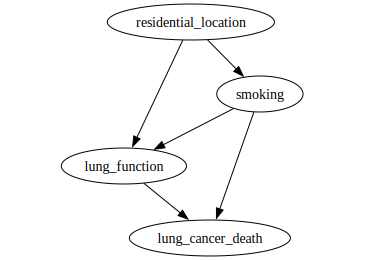

In [125]:
dot = model.to_graphviz()
dot.graph_attr.update(ratio=0.7)
graphviz.Source(dot.to_string())

In [126]:
N = 10_000

df = model.simulate(n_samples=N, show_progress=False)
df.sample(10)

,lung_cancer_death,residential_location,smoking,lung_function
3467,0,Rural,No,normal
167,0,Urban,No,impaired
9746,1,Urban,Yes,severely_impaired
7090,0,Urban,No,impaired
1064,0,Urban,Yes,normal
7768,0,Urban,Yes,impaired
2539,1,Urban,Yes,impaired
6431,1,Urban,Yes,impaired
2960,0,Urban,No,severely_impaired
8831,1,Urban,Yes,severely_impaired


In [127]:
df['lung_function'] = df['lung_function'].astype('category')

# set an explicit reference category
df['lung_function'] = pd.Categorical(
    df['lung_function'],
    categories=['normal', 'impaired', 'severely_impaired'],
    ordered=False
)

## CPD sanity checks

In [128]:
df['residential_location'].value_counts(normalize=True).to_frame().round(2)

,proportion
residential_location,
Urban,0.8
Rural,0.2


In [129]:
df.groupby('residential_location')['smoking'].value_counts(normalize=True).to_frame().round(2).sort_index()

proportion
residential_location smoking            
Rural                No              0.9
                     Yes             0.1
Urban                No              0.1
                     Yes             0.9

In [130]:
df.groupby(['residential_location', 'smoking'])['lung_function'].value_counts(normalize=True).to_frame().round(2).sort_index()

proportion
residential_location smoking lung_function                
Rural                No      normal                   0.55
                             impaired                 0.27
                             severely_impaired        0.18
                     Yes     normal                   0.13
                             impaired                 0.37
                             severely_impaired        0.50
Urban                No      normal                   0.46
                             impaired                 0.30
                             severely_impaired        0.24
                     Yes     normal                   0.09
                             impaired                 0.42
                             severely_impaired        0.49

In [131]:
df.groupby('lung_function', observed=False)['lung_cancer_death'].value_counts(normalize=True).to_frame().round(2).sort_index()

proportion
lung_function     lung_cancer_death            
normal            0                        0.43
                  1                        0.57
impaired          0                        0.29
                  1                        0.71
severely_impaired 0                        0.26
                  1                        0.74

# Fit a model with all covariates

In [ ]:
model_full = smf.glm(
    formula='lung_cancer_death ~ smoking + lung_function + residential_location',
    data=df,
    family=sm.families.Binomial()
).fit()

print(model_full.summary())

y_pred_probs = model_full.predict(df)
y_true = df['lung_cancer_death']
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"\nROC AUC: {roc_auc:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:      lung_cancer_death   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5817.8
Date:                Fri, 11 Apr 2025   Deviance:                       11636.
Time:                        11:55:13   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06219
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [133]:
urban_log_OR = pd.read_html(StringIO(model_full.summary().tables[1].as_html()), header=0, index_col=0)[0].loc['residential_location[T.Urban]', 'coef']

print(f'ESTIMATED odds ratio for urban over rural: {np.exp(urban_log_OR):.2f}\nESTIMATED log odds ratio urban over rural: {urban_log_OR:.2f}')

ESTIMATED odds ratio for urban over rural: 1.00
ESTIMATED log odds ratio urban over rural: -0.00


In [134]:
# It ain't pretty syntax, but it gets the job done.
full_model_OR = np.exp(pd.read_html(StringIO(model_full.summary().tables[1].as_html()), header=0, index_col=0)[0]['coef'])\
    .to_frame().rename(columns={'coef': 'full_model_OR'})

full_model_OR.round(2)

,full_model_OR
Intercept,0.94
smoking[T.Yes],3.19
lung_function[T.impaired],1.09
lung_function[T.severely_impaired],1.14
residential_location[T.Urban],1.00


## Independence tests

In [135]:
chi_sq_results = {}

for col in set(df.columns) - {'lung_cancer_death'}:
    contingency_table = pd.crosstab(df[col], df['lung_cancer_death'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    chi_sq_results[col] = {
        'chi2': chi2,
        'p_value': p_value
    }

pd.DataFrame(chi_sq_results).T

,chi2,p_value
residential_location,356.455980,1.664541e-79
smoking,668.718542,1.897951e-147
lung_function,197.473016,1.316071e-43


# Marginal Odds-Ratios

In [136]:
manual_OR = {}

manual_OR['residential_location'] = get_OR_for_treatment(
    df[df['residential_location'] == 'Urban'],
    df[df['residential_location'] == 'Rural']
)

manual_OR['smoking'] = get_OR_for_treatment(
    df[df['smoking'] == 'Yes'],
    df[df['smoking'] == 'No']
)

manual_OR['lung_function_sev_imp'] = get_OR_for_treatment(
    df[df['lung_function'] == 'severely_impaired'],
    df[df['lung_function'] == 'impaired']
)

manual_OR['lung_function_imp'] = get_OR_for_treatment(
    df[df['lung_function'] == 'normal'],
    df[df['lung_function'] == 'impaired']
)

manual_OR = pd.Series(manual_OR, name='manual_OR').to_frame()
manual_OR.round(2)

,manual_OR
residential_location,2.60
smoking,3.35
lung_function_sev_imp,1.15
lung_function_imp,0.53


## Residential Location

In [137]:
model_adj = smf.glm(
    formula='lung_cancer_death ~ residential_location',
    data=df,
    family=sm.families.Binomial()
).fit()

print(model_adj.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      lung_cancer_death   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5969.9
Date:                Fri, 11 Apr 2025   Deviance:                       11940.
Time:                        11:55:13   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03323
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [138]:
samples_urban = model.simulate(n_samples=N, do={'residential_location': 'Urban'}, show_progress=False)
samples_rural = model.simulate(n_samples=N, do={'residential_location': 'Rural'}, show_progress=False)

residential_location_OR = get_OR_for_treatment(samples_urban, samples_rural)   
print(f'True odds ratio: {residential_location_OR:.4f}\nTrue log odds ratio: {np.log(residential_location_OR):.4f}')

True odds ratio: 2.6162
True log odds ratio: 0.9617


## Smoking

In [139]:
model_adj = smf.glm(
    formula='lung_cancer_death ~ residential_location + smoking',
    data=df,
    family=sm.families.Binomial()
).fit()

print(model_adj.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      lung_cancer_death   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5819.8
Date:                Fri, 11 Apr 2025   Deviance:                       11640.
Time:                        11:55:13   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06182
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [140]:
samples_smoke_no = model.simulate(n_samples=N, do={'smoking': 'No'}, show_progress=False)
samples_smoke_yes = model.simulate(n_samples=N, do={'smoking': 'Yes'}, show_progress=False)

smoking_OR = get_OR_for_treatment(samples_smoke_yes, samples_smoke_no)  
print(f'True odds ratio: {smoking_OR:.4f}\nTrue log odds ratio: {np.log(smoking_OR):.4f}')

True odds ratio: 3.4160
True log odds ratio: 1.2285


## Lung Function

In [141]:
model_adj = smf.glm(
    formula='lung_cancer_death ~ lung_function + smoking',
    data=df,
    family=sm.families.Binomial()
).fit()

print(model_adj.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      lung_cancer_death   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5817.8
Date:                Fri, 11 Apr 2025   Deviance:                       11636.
Time:                        11:55:14   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06219
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [142]:
samples_lung_fun_ref = model.simulate(n_samples=N, do={'lung_function': 'impaired'}, show_progress=False)
samples_lung_fun_imp = model.simulate(n_samples=N, do={'lung_function': 'normal'}, show_progress=False)
samples_lung_fun_sev_imp = model.simulate(n_samples=N, do={'lung_function': 'severely_impaired'}, show_progress=False)

lung_fun_imp_OR = get_OR_for_treatment(samples_lung_fun_imp, samples_lung_fun_ref)
lung_fun_sev_imp_OR = get_OR_for_treatment(samples_lung_fun_sev_imp, samples_lung_fun_ref)

print(f'True odds ratio (normal): {lung_fun_imp_OR:.4f}\nTrue log odds ratio (normal): {np.log(lung_fun_imp_OR):.4f}')
print(f'\nTrue odds ratio (severely_impaired): {lung_fun_sev_imp_OR:.4f}\nTrue log odds ratio (severely_impaired): {np.log(lung_fun_sev_imp_OR):.4f}')

True odds ratio (normal): 1.0136
True log odds ratio (normal): 0.0135

True odds ratio (severely_impaired): 0.9890
True log odds ratio (severely_impaired): -0.0111


### Summarize true odds ratios

In [143]:
true_OR = pd.Series({
    'residential_location': residential_location_OR,
    'smoking': smoking_OR,
    'lung_function_imp': lung_fun_imp_OR,
    'lung_function_sev_imp': lung_fun_sev_imp_OR
}, name='true_OR').to_frame()

true_OR.round(2)

,true_OR
residential_location,2.62
smoking,3.42
lung_function_imp,1.01
lung_function_sev_imp,0.99


# SHAP values

ROC AUC: 0.63


,Feature,Mean Absolute SHAP Value
1,smoking_Yes,0.477
3,lung_function_severely_impaired,0.040
2,lung_function_impaired,0.017
0,residential_location_Urban,0.012


/var/folders/c8/1z0fkgc168774_b4ld13pjrr0000gp/T/ipykernel_59955/1808494397.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="bar")


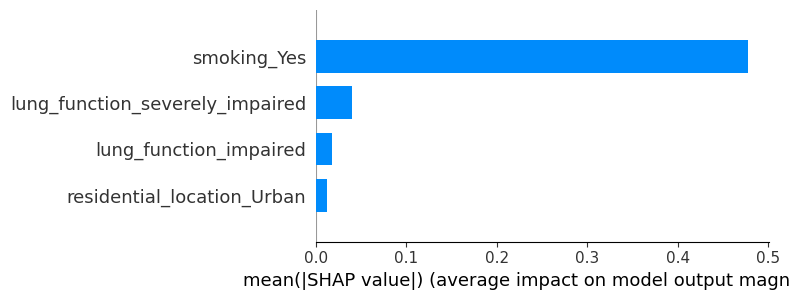

In [144]:
X = pd.get_dummies(df.drop("lung_cancer_death", axis=1), drop_first=True)
y = df["lung_cancer_death"]

xgb_model = xgb.XGBClassifier(random_state=1)
xgb_model.fit(X, y)

roc_auc = roc_auc_score(y, xgb_model.predict_proba(X)[:, 1])
print(f"ROC AUC: {roc_auc:.2f}")

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# Create a DataFrame summarizing the mean absolute SHAP values per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_summary_df = pd.DataFrame({
    "Feature": X.columns,
    "Mean Absolute SHAP Value": mean_abs_shap
}).sort_values("Mean Absolute SHAP Value", ascending=False)

display(shap_summary_df.round(3))

shap.summary_plot(shap_values, X, plot_type="bar")

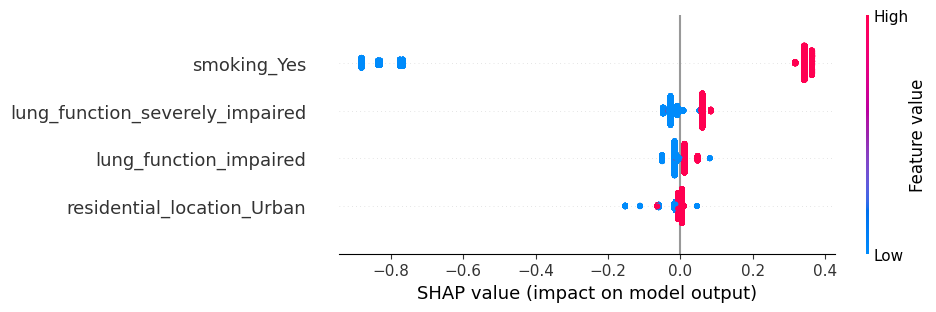

In [145]:
shap.plots.beeswarm(explainer(X))

# Results

In [146]:
full_model_OR.drop(index=['Intercept'], inplace=True)
full_model_OR.rename(index={'smoking[T.Yes]': 'smoking', 'lung_function[T.normal]': 'lung_function_imp', 'lung_function[T.impaired]': 'lung_function_imp',
                              'lung_function[T.severely_impaired]': 'lung_function_sev_imp', 'residential_location[T.Urban]': 'residential_location'
                              }, inplace=True)
shap_summary_df = shap_summary_df.set_index('Feature').rename(index=
                                                              {'smoking_Yes': 'smoking', 'lung_function_severely_impaired': 'lung_function_sev_imp',
                                                               'lung_function_impaired': 'lung_function_imp', 'lung_function_normal': 'lung_function_imp', 
                                                               'residential_location_Urban': 'residential_location'})

results = full_model_OR.merge(true_OR, left_index=True, right_index=True)\
    .merge(manual_OR, left_index=True, right_index=True)\
    .merge(shap_summary_df, left_index=True, right_index=True)

In [147]:
results.round(2)

,full_model_OR,true_OR,manual_OR,Mean Absolute SHAP Value
smoking,3.19,3.42,3.35,0.48
lung_function_imp,1.09,1.01,0.53,0.02
lung_function_sev_imp,1.14,0.99,1.15,0.04
residential_location,1.00,2.62,2.60,0.01


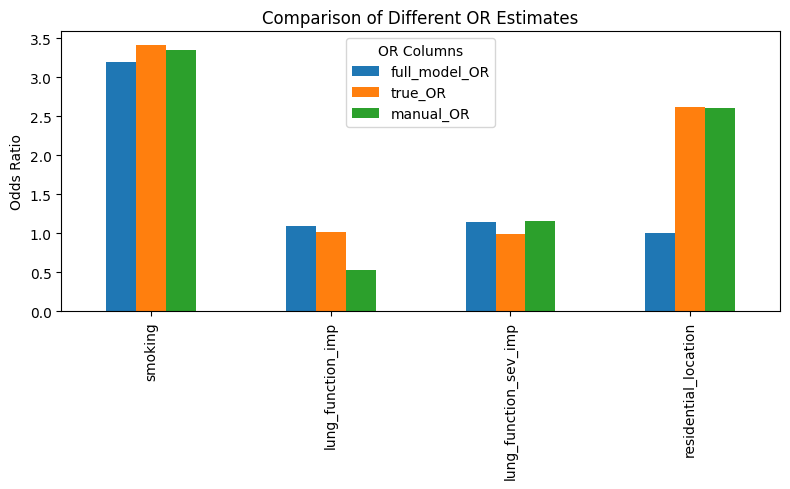

In [148]:
plot_col_mask = results.columns.str.endswith('_OR')
ax = results.loc[:, plot_col_mask].plot(kind='bar', figsize=(8, 5))
ax.set_ylabel("Odds Ratio")
ax.set_title("Comparison of Different OR Estimates")

plt.legend(title="OR Columns", loc="best")
plt.tight_layout()
plt.show()

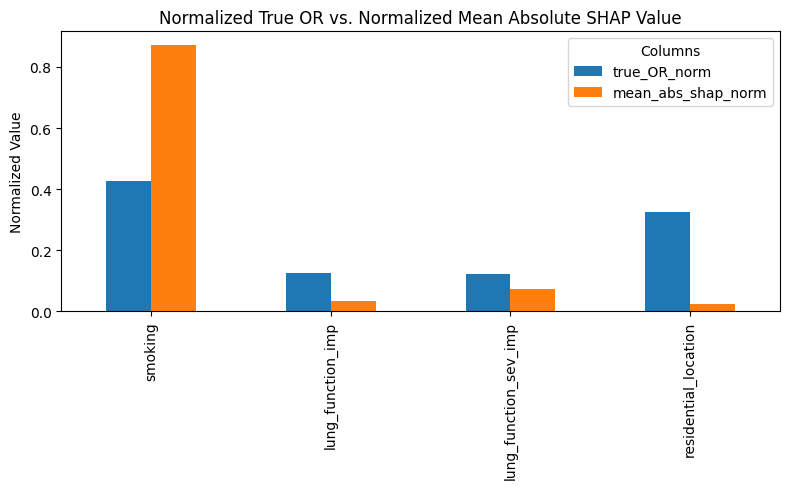

In [149]:
# Normalize "true_OR" so it sums to 1
results["true_OR_norm"] = results["true_OR"] / results["true_OR"].sum()

# Normalize "Mean Absolute SHAP Value" so it sums to 1
results["mean_abs_shap_norm"] = (
    results["Mean Absolute SHAP Value"] / results["Mean Absolute SHAP Value"].sum()
)

ax = results[["true_OR_norm", "mean_abs_shap_norm"]].plot(kind="bar", figsize=(8, 5))
ax.set_ylabel("Normalized Value")
ax.set_title("Normalized True OR vs. Normalized Mean Absolute SHAP Value")
plt.legend(title="Columns", loc="best")
plt.tight_layout()
plt.show()

# TODO

* write the outline for the post
* prepare the example of things that occur before others as listed below.

NOTE: country and account, for example, are always determined before exp, edu, top-category, etc., and so we cannot say (ever) that they do not cause them. i.e., we can't say - residential_location has not effect on years of experience, or the average education, etc.

Prepare an intuitive / graphical example of the above.


---
```
dag {
bb="0,0,1,1"
smokingcation [adjusted,pos="0.364,0.242"]
lung_functionerience [adjusted,pos="0.416,0.405"]
residential_location [exposure,pos="0.237,0.333"]
dism_OQ [outcome,pos="0.572,0.341"]
smokingcation -> lung_functionerience
smokingcation -> dism_OQ
lung_functionerience -> dism_OQ
residential_location -> smokingcation
residential_location -> lung_functionerience
}
```

# DRAFT

In [150]:
full_model_OR

,full_model_OR
smoking,3.188976
lung_function_imp,1.085564
lung_function_sev_imp,1.140424
residential_location,0.997603


In [151]:
shap_summary_df

,Mean Absolute SHAP Value
Feature,
smoking,0.477242
lung_function_sev_imp,0.039884
lung_function_imp,0.017349
residential_location,0.012070


In [152]:
X

,residential_location_Urban,smoking_Yes,lung_function_impaired,lung_function_severely_impaired
0,True,True,True,False
1,True,True,False,False
2,True,True,True,False
3,False,False,False,True
4,True,True,False,True
...,...,...,...,...
9995,True,True,True,False
9996,True,True,False,True
9997,True,True,False,True
9998,True,True,True,False


In [153]:
df

,lung_cancer_death,residential_location,smoking,lung_function
0,1,Urban,Yes,impaired
1,0,Urban,Yes,normal
2,1,Urban,Yes,impaired
3,1,Rural,No,severely_impaired
4,1,Urban,Yes,severely_impaired
...,...,...,...,...
9995,1,Urban,Yes,impaired
9996,1,Urban,Yes,severely_impaired
9997,0,Urban,Yes,severely_impaired
9998,1,Urban,Yes,impaired
